# ts_aos_analysis

# AOS  DM-46763:  WET-007 Compare CWFS approaches with WET-001 LsstCam data

For https://rubinobs.atlassian.net/browse/SITCOM-1149

Last verified to run 2024/10/09

Versions:

* lsst_distrib w_2024_37 (ext, cvmfs)

* ts_wep v11.4.0




## Imports 

In [81]:
from lsst.daf import butler as dafButler
from lsst.ts.wep.task.generateDonutDirectDetectTask import (GenerateDonutDirectDetectTask,GenerateDonutDirectDetectTaskConfig)
from copy import copy
from lsst.obs.lsst import LsstCam
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval
from matplotlib import colormaps as cmaps

## Employ the central butler repository  to ingest raws,  perform ISR, and run WEP.

In [1]:
butlerRootPath = '/sdf/data/rubin/repo/aos_imsim/'
outputImgDir = (
    "/sdf/data/rubin/user/gmegias/projects/commissioning_sims/WET-001_lsstcam/state_*"
)


butlerInstName = "Cam"
cmd4 = f"butler ingest-raws {butlerRootPath} {outputImgDir}/amp*"
print(cmd4, "\n")

butler ingest-raws /sdf/data/rubin/repo/aos_imsim/ /sdf/data/rubin/user/gmegias/projects/commissioning_sims/WET-001_lsstcam/state_*/amp* 



butler ingest-raws /sdf/data/rubin/repo/aos_imsim/ /sdf/data/rubin/user/gmegias/projects/commissioning_sims/WET-001_lsstcam/state_100/amp*

Run 

     butler define-visits /sdf/data/rubin/repo/aos_imsim   lsst.obs.lsst.LsstCam


Make `site_bps.yaml`, containing  


    site:
      s3df:
        profile:
          condor:
            +Walltime: 7200

In [ ]:
Check a particular state:

In [7]:
butler = dafButler.Butler(butlerRootPath)

dataRefs = butler.registry.queryDatasets('raw', collections=['LSSTCam/raw/all'],
                             where=f"instrument='LSSTCam' and visit = 5024072302002").expanded()
for ref in dataRefs:
    print(ref)

raw@{instrument: 'LSSTCam', detector: 199, exposure: 5024072302002, band: 'r', day_obs: 20240723, group: '5024072302002', physical_filter: 'r_57'} [sc=Exposure] (run=LSSTCam/raw/all id=f35fec11-a4a2-5a41-ad1d-556b71be480e)
raw@{instrument: 'LSSTCam', detector: 191, exposure: 5024072302002, band: 'r', day_obs: 20240723, group: '5024072302002', physical_filter: 'r_57'} [sc=Exposure] (run=LSSTCam/raw/all id=0f9bf977-30d5-57c6-872f-8447ee5d218e)
raw@{instrument: 'LSSTCam', detector: 196, exposure: 5024072302002, band: 'r', day_obs: 20240723, group: '5024072302002', physical_filter: 'r_57'} [sc=Exposure] (run=LSSTCam/raw/all id=134e32fd-a9f1-54b4-8ec6-3b0ea7fc5644)
raw@{instrument: 'LSSTCam', detector: 192, exposure: 5024072302002, band: 'r', day_obs: 20240723, group: '5024072302002', physical_filter: 'r_57'} [sc=Exposure] (run=LSSTCam/raw/all id=5f355c95-6c3f-51e3-a879-872660145174)
raw@{instrument: 'LSSTCam', detector: 200, exposure: 5024072302002, band: 'r', day_obs: 20240723, group: '50

This shows that 8 detectors are available for state 2. 

Check how many exposures got ingested:

In [8]:
butlerRootPath = '/sdf/data/rubin/repo/aos_imsim/'
butler = dafButler.Butler(butlerRootPath)
dataRefs = butler.registry.queryDatasets('raw', collections=['LSSTCam/raw/all'],
                             where=f"instrument='LSSTCam' and visit.day_obs = 20240723 and exposure.science_program = 'wet001_100_dof_states'").expanded()
print(len(list(dataRefs)))


792


Expected 800 exposures (100 states x 8 detectors).  As if 8 exposures (1 state) was missing. Find out which one ?

In [9]:
seq_nums = []
for ref in refs:
    seq_nums.append(ref.dataId.exposure.seq_num)

In [10]:
import numpy as np 
np.unique(seq_nums)

array([2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022,
       2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033,
       2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044,
       2045, 2046, 2047, 2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055,
       2056, 2057, 2058, 2059, 2060, 2061, 2062, 2063, 2064, 2065, 2066,
       2067, 2068, 2069, 2070, 2071, 2072, 2073, 2074, 2075, 2076, 2077,
       2078, 2079, 2080, 2081, 2082, 2083, 2084, 2085, 2086, 2087, 2088,
       2089, 2090, 2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099])

In [15]:
expected_seq_nums = np.arange(2001,2101)
expected_seq_nums[~np.in1d(expected_seq_nums, np.unique(seq_nums), )]

array([2100])

In [12]:
ok, so the last state appears not to have ingested.  Ingest it manually. 

100

Then run ISR with bps:
    
    cd /sdf/group/rubin/shared/scichris/DM-46763_WET-007
    allocateNodes.py -v -n 10 -c 64 -m 60:00:00 -q milano -g 1800 s3df --account rubin:developers


    bps submit site_bps.yaml  -b  /sdf/data/rubin/repo/aos_imsim -i  LSSTCam/raw/all,LSSTCam/calib/unbounded -o WET-001_lsstCam_ISR -p /sdf/group/rubin/shared/scichris/DM-46763_WET-007/lsstPipelineISRdoVar.yaml -d "instrument='LSSTCam' and exposure.science_program = 'wet001_100_dof_states'"


    Run Id: 3131919.0
    Run Name: WET-001_lsstCam_ISR_20241009T235016Z
    
    bps report --id 3131919.0

All worked.  Now we can run donut direct detection. 


## Run donut detection in interactive mode to test sigma levels


In [33]:
dataRefs = butler.registry.queryDatasets('postISRCCD', collections=['WET-001_lsstCam_ISR'],
    where=f"instrument='LSSTCam' and exposure.science_program = 'wet001_100_dof_states' \
    and exposure.seq_num = 2001 and detector = 192").expanded()
ref = list(dataRefs)[0]
exp = butler.get('postISRCCD', dataId = ref.dataId,  collections = ['WET-001_lsstCam_ISR'])

INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 20 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 20 of 20 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 20 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 20 of 20 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 12/20 references


Text(0.5, 1.0, 'det 191')

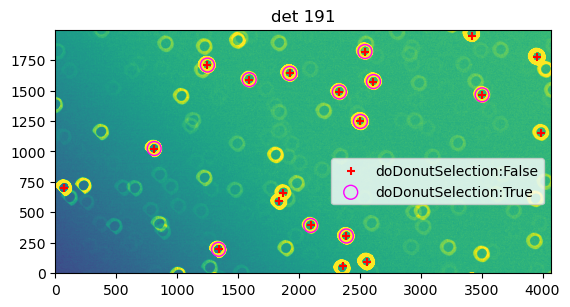

In [41]:
zscale = ZScaleInterval()

camera = LsstCam().getCamera()

config = GenerateDonutDirectDetectTaskConfig()
#config.measurementTask.nPixMinDetection = 2 # instead of 10
config.measurementTask.nSigmaDetection = 5
config.donutSelector.useCustomMagLimit = True

fig = plt.figure()

d = exp.image.array
vmin,vmax = zscale.get_limits(d)
plt.imshow(d, vmin=vmin, vmax=vmax, origin='lower')

# detect all donuts and overplot 
config.doDonutSelection = False

task = GenerateDonutDirectDetectTask(config=config)
taskOut = task.run(copy(exp), camera)
plt.scatter(taskOut.donutCatalog['centroid_x'], taskOut.donutCatalog['centroid_y'], 
            marker='+', c='r', label=f'doDonutSelection:{config.doDonutSelection}'
                )
# show the impact of turning on donut selector
config.doDonutSelection = True
task = GenerateDonutDirectDetectTask(config=config)
taskOut = task.run(copy(exp), camera)
#donutCats[detId] = taskOut.donutCatalog
plt.scatter(taskOut.donutCatalog['centroid_x'], taskOut.donutCatalog['centroid_y'], 
            marker='o', s=100, facecolors='none', edgecolors='magenta' ,label=f'doDonutSelection:{config.doDonutSelection}'
                )
plt.legend(bbox_to_anchor=[1.0,0.5])
plt.title(f'det {detId}')


This threshold selects many donuts, and donut selector appears to remove those close to the edge. 

## Run donut detection, cutouts, and Zernike estimation, all with bps

We run each step separately to reuse the same `postISRCCD` and `donutStampsExtra`, `donutStampsIntra`. To run `bps` we need to:

    cd /sdf/group/rubin/shared/scichris/DM-46763_WET-007
    allocateNodes.py -v -n 10 -c 64 -m 60:00:00 -q milano -g 1800 s3df --account rubin:developers
    lsst
    aos
    



In [81]:
isrCollection =     "WET-001_lsstCam_ISR"
cutoutsCollection = "WET-001_lsstCam_direct_stamps"
tieCollection =     "WET-001_lsstCam_direct_TIE1"
danishCollection =  "WET-001_lsstCam_direct_Danish1"

isrYaml = "lsstPipelineISRdoVar.yaml"
cutoutYaml = "lsstPipelineDirectCutoutOnly.yaml"
danishYaml = "lsstPipelineCalcDanishOnly.yaml"
tieYaml = "lsstPipelineCalcTieOnly.yaml"

pathCwd = '/sdf/group/rubin/shared/scichris/DM-46763_WET-007'
isrYamlPath = os.path.join(pathCwd, isrYaml)
cutoutYamlPath = os.path.join(pathCwd, cutoutYaml)
danishYamlPath = os.path.join(pathCwd, danishYaml)
tieYamlPath = os.path.join(pathCwd, tieYaml)

cmdCutout = f"bps submit site_bps.yaml  -b  {butlerRootPath} -i {isrCollection},LSSTCam/calib/unbounded \
-o {cutoutsCollection}  -p {cutoutYamlPath}"

cmdDanish = f"bps submit site_bps.yaml  -b  {butlerRootPath} -i {cutoutsCollection} \
-o {danishCollection}  -p {danishYamlPath} "

cmdTie = f"bps submit site_bps.yaml  -b  {butlerRootPath} -i {cutoutsCollection} \
-o {tieCollection}  -p {tieYamlPath}"

print(cmdCutout, "\n")
print(cmdDanish, "\n")
print(cmdTie, "\n")


bps submit site_bps.yaml  -b  /sdf/data/rubin/repo/aos_imsim/ -i WET-001_lsstCam_ISR,LSSTCam/calib/unbounded -o WET-001_lsstCam_direct_stamps  -p /sdf/group/rubin/shared/scichris/DM-46763_WET-007/lsstPipelineDirectCutoutOnly.yaml 

bps submit site_bps.yaml  -b  /sdf/data/rubin/repo/aos_imsim/ -i WET-001_lsstCam_direct_stamps -o WET-001_lsstCam_direct_Danish1  -p /sdf/group/rubin/shared/scichris/DM-46763_WET-007/lsstPipelineCalcDanishOnly.yaml  

bps submit site_bps.yaml  -b  /sdf/data/rubin/repo/aos_imsim/ -i WET-001_lsstCam_direct_stamps -o WET-001_lsstCam_direct_TIE1  -p /sdf/group/rubin/shared/scichris/DM-46763_WET-007/lsstPipelineCalcTieOnly.yaml 



To the calculation of Zernikes I added 

    config.estimateZernikes.saveHistory=True

as well as subsequent tasks

      aggregateZernikesTask: lsst.donut.viz.AggregateZernikesTask
      aggregateDonutCatalogsTask: lsst.donut.viz.AggregateDonutCatalogsTask
      aggregateAOSVisitTableTask: lsst.donut.viz.AggregateAOSVisitTableTask
      plotAOSTask: lsst.donut.viz.PlotAOSTask
      aggregateDonutStampsTask: lsst.donut.viz.AggregateDonutStampsTask
      plotDonutTask: lsst.donut.viz.PlotDonutTask
      

Check that the cutouts are there:

In [42]:
from lsst.daf import butler as dafButler
butlerRootPath = '/sdf/data/rubin/repo/aos_imsim/'
butler = dafButler.Butler(butlerRootPath)
dataRefs = butler.registry.queryDatasets('donutStampsExtra', collections=['WET-001_lsstCam_direct_stamps'],
                             where=f"instrument='LSSTCam' and visit.seq_num = 2002").expanded()
ref = list(dataRefs)[0]

In [43]:
ref

DatasetRef(DatasetType('donutStampsExtra', {band, instrument, day_obs, detector, physical_filter, visit}, StampsBase), {instrument: 'LSSTCam', detector: 191, visit: 5024072302002, band: 'r', day_obs: 20240723, physical_filter: 'r_57'}, run='WET-001_lsstCam_direct_stamps/20241010T051647Z', id=d985ac7b-d952-4d18-865f-97a022e72c21)

In [44]:
donutStampsExtra = butler.get('donutStampsExtra', dataId=ref.dataId, collections=['WET-001_lsstCam_direct_stamps'])

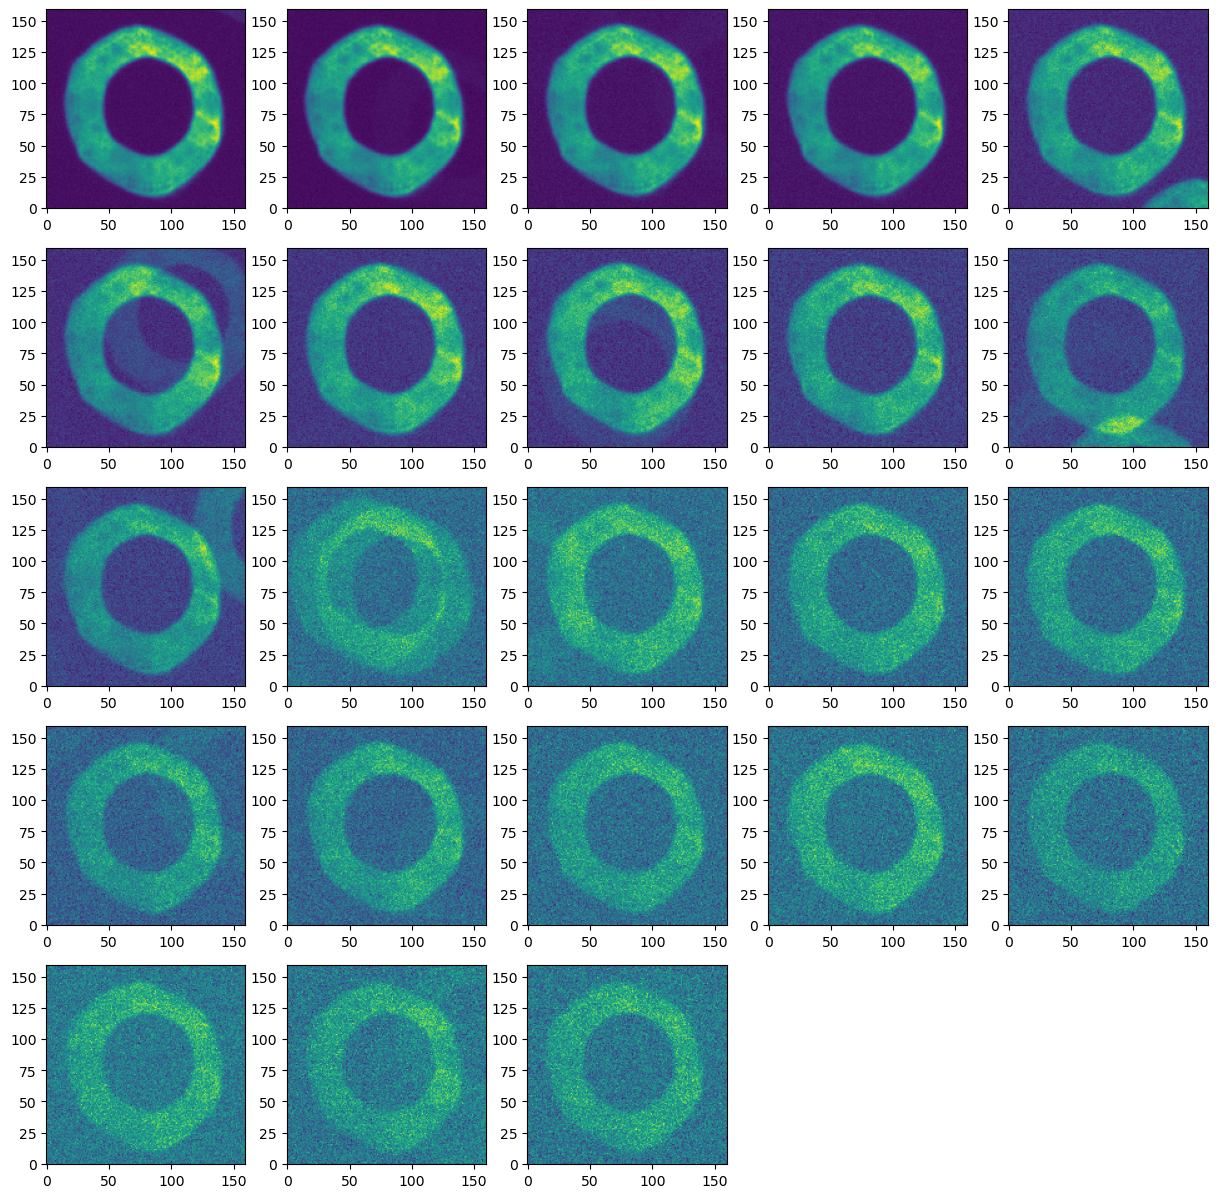

In [94]:
fig,axs = plt.subplots(5,5, figsize=(15,15))
ax = np.ravel(axs)
i=0
donutStamps = donutStampsExtra
for stamp in donutStamps:
    ax[i].imshow(stamp.stamp_im.image.array, origin='lower')
    i += 1 
if len(donutStamps)<len(ax):
    for i in range(len(donutStamps), len(ax)):
        ax[i].axis('off')

## Check if all states have Zernike estimates 

In [46]:
butlerRootPath = '/sdf/data/rubin/repo/aos_imsim/'
butler = dafButler.Butler(butlerRootPath)

for method in ['Danish', 'TIE']:
    dataRefs = butler.registry.queryDatasets('zernikeEstimateRaw', collections=[f'WET-001_lsstCam_direct_{method}1'],
                                 where=f"instrument='LSSTCam' ").expanded()
    refs=[]
    for ref in dataRefs:
        refs.append(ref)
    n = len(refs)
    print(f'There are {n} Zk estimates for {method}')

There are 396 Zk estimates for Danish
There are 396 Zk estimates for TIE


Since there were 792 raw images, half (one Zk estimate per sensor pair) would be 396.

## Compare TIE to Danish results:

Read the OPD values :

In [55]:
from astropy.io import fits 
# load all OPDs to a dict
all_opd = {}
for n in range(1,101):#101):
    opdDir = f'/sdf/data/rubin/user/gmegias/projects/commissioning_sims/WET-001_lsstcam/state_{n}'

    hdul = fits.open(os.path.join(opdDir,'opd.fits'))

    
    opds = {}
    for i in range(len(hdul)):
        opd_zks_1_28 = []
        for key,value in hdul[i].header.items():
            
            if key.startswith('AZ'):
                #print(key.split('_')[1])
                opd_zks_1_28.append(value)
        opds[i] = opd_zks_1_28
    all_opd[n]  = opds
    
opd_raft_to_id = {'R00':0, 'R04':1, 'R40':2, 'R44':3}  


Read the results:

In [50]:
from lsst.daf import butler as dafButler
butlerRootPath = '/sdf/data/rubin/repo/aos_imsim/'
butler = dafButler.Butler(butlerRootPath)
registry = butler.registry
output_collection = 'WET-001_lsstCam_direct_TIE1'
datasetRefs = registry.queryDatasets('donutStampsExtra', collections=[output_collection],
                                     where=f"instrument='LSSTCam' and detector.purpose='WAVEFRONT' ").expanded()
refs = []
for ref in datasetRefs:
    refs.append(ref)
print(len(refs))

396


In [51]:
pairing_results = {'tie':{}, 'danish':{}}
for method in pairing_results.keys():
    pairing_results[method] = {}
    for state in range(1,100):
        pairing_results[method][state] = {}

In [52]:
for ref in refs:
    # read in the results of each method 
    for method in pairing_results.keys():
        if method == 'tie':
            coll_method = 'TIE'  
        else:
            coll_method = 'Danish'
        coll = f'WET-001_lsstCam_direct_{coll_method}1'
        state = int(str(ref.dataId.visit.id)[-3:]) 
        raft = ref.dataId.detector.raft
        
        pairing_results[method][state][raft] =  butler.get('zernikeEstimateAvg', 
                          dataId=ref.dataId, 
                          collections=[coll])

Compare TIE to Danish:

In [53]:
def plot_lsstcam_fit_vs_opd(state, opd_raft_to_id, all_opd, pairing_results):
    rafts = ['R04', 'R44', 'R00','R40']
    fig,axs = plt.subplots(2,2,figsize=(16,8))
    ax = np.ravel(axs)
    i=0
    
    # this plots  just the pairing results 
    colors = {'danish':'green',  'tie':'orange'}
    for raft in rafts:
        
        ax[i].set_title(raft )
        opdId = opd_raft_to_id[raft] 
        opd_zk = 0.001*np.array(all_opd[state][opdId][3:29])
        
        for method in pairing_results.keys():
            # plot pairing  raw zks for danish and tie
            zkRaw = pairing_results[method][state][raft]
            avg_zk = np.mean(zkRaw, axis=0)
         
            rms_diff_avg =  np.sqrt(np.mean(np.square(avg_zk-opd_zk)))
            ax[i].plot(np.arange(4,29), avg_zk-opd_zk, marker='d', label=f'{method} $\Delta$rms={rms_diff_avg:.3f} microns')
          
        ax[i].set_ylabel(r'$\Delta$ (fit-OPD) [microns]')
        ax[i].set_xlabel('Zk mode')
        ax[i].set_xticks(np.arange(4,29,step=2))
        ax[i].axhline(0,ls='--', c='red')
        ax[i].legend()
        i+=1
       
    
    fig.subplots_adjust(hspace=0.3)
    fig.suptitle(f'WET-006 lsstCam, state {state}, \n pairing only (using zernikeEstimateAvg) : TIE vs Danish')

Plot comparison between TIE and Danish, showing the difference from the OPD for a single state:

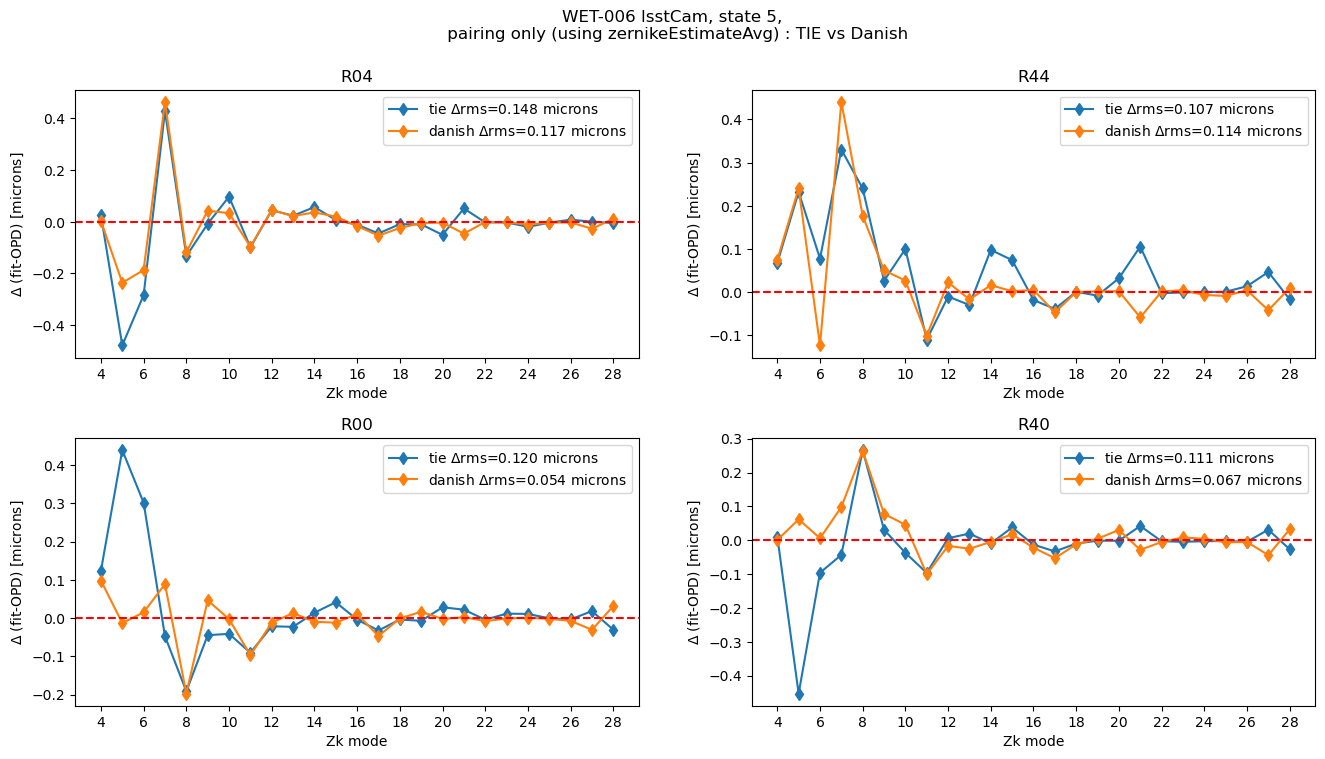

In [56]:
plot_lsstcam_fit_vs_opd(5, opd_raft_to_id, all_opd, pairing_results)

For each state we have one RMS difference between fitted value and the  OPD.  We can calculate it for all states:

In [58]:
rmss={}
rafts = ['R04', 'R44', 'R00','R40']
# add pairing results 
for algo in pairing_results.keys():
   rmss[algo] = {}
   for raft in rafts:
       rmss[algo][raft] = []
       opdId = opd_raft_to_id[raft] 
       #print(algo, raft, )
       for state in pairing_results[algo].keys():
            #print(state)
            opd_zk = 0.001*np.array(all_opd[state][opdId][3:29])
            avg_zk = np.mean(pairing_results[algo][state][raft], axis=0)
            rms_diff =  np.sqrt(np.mean(np.square(avg_zk-opd_zk)))
            rmss[algo][raft].append(rms_diff)
            if rms_diff > 10:
                print(algo, raft, state, rms_diff)

tie R04 45 1289.5422211020345
tie R44 45 113.45955258359294
tie R00 45 251.4142584734439
tie R40 45 101.10504202327914


Plot a summary RMS difference per state for all states: this highlights if there is any particular optical state that either algorithm performed more poorly:

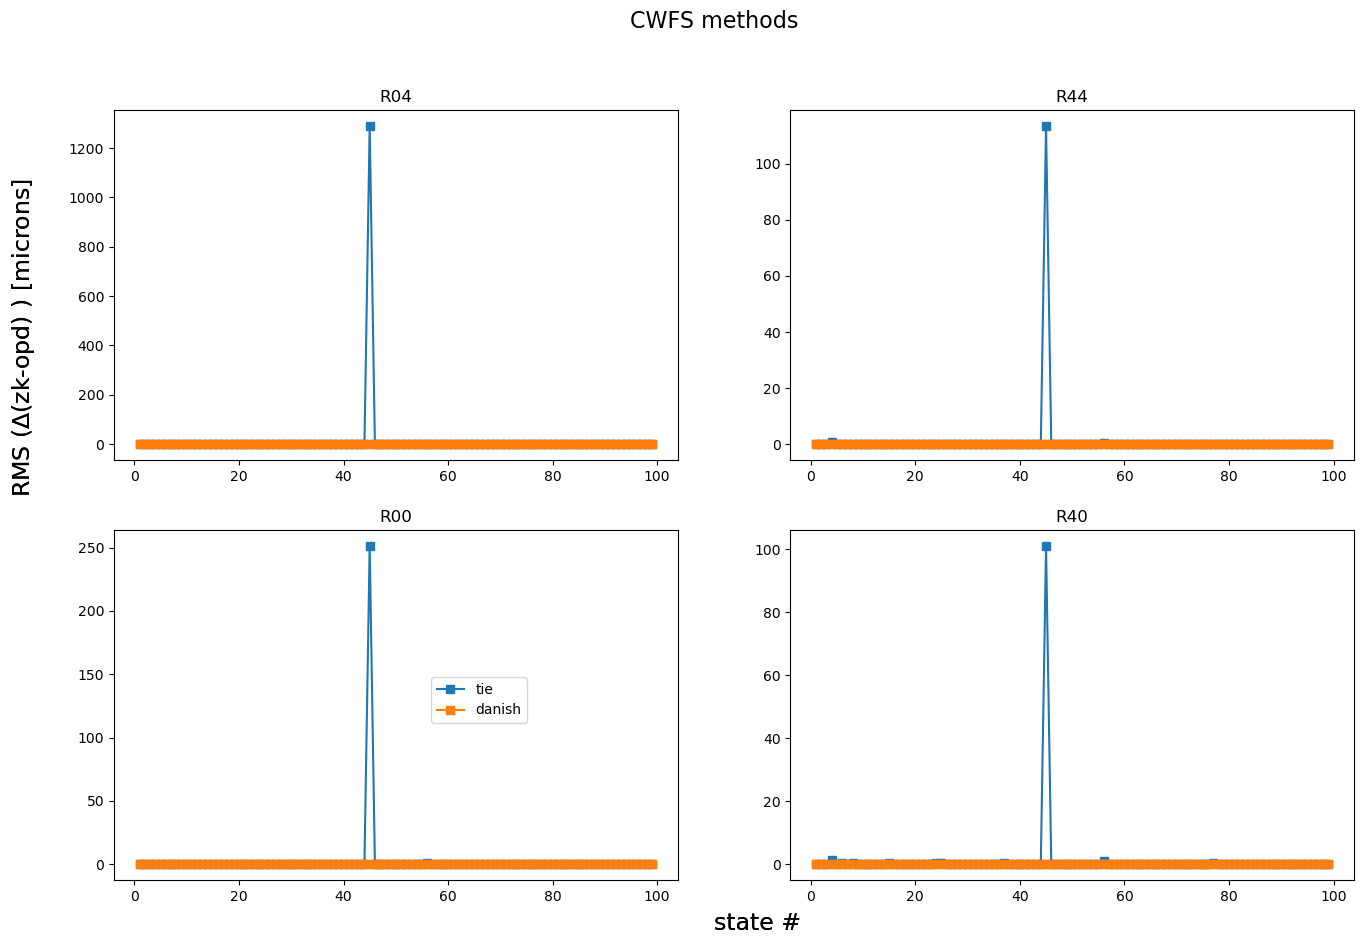

In [59]:
fig,axs = plt.subplots(2,2,figsize=(16,10))
ax = np.ravel(axs)

for method in rmss.keys():
    i=0
    for raft in rafts:
        ax[i].plot(pairing_results[algo].keys(), rmss[method][raft], marker='s', label=f'{method}')
        ax[i].set_title(raft)
        i+=1
    
    fig.text(0.5,0.06,'state #', fontsize=17)
    fig.text(0.06,0.5,r'RMS ($\Delta$(zk-opd) ) [microns] ', rotation=90, fontsize=17)
fig.suptitle('CWFS methods', fontsize=16)
ax[2].legend(bbox_to_anchor=[0.55,.6])

This shows that there is a state that's worse than all the other. Which one? 

array([45])

Plot everything apart form that state:

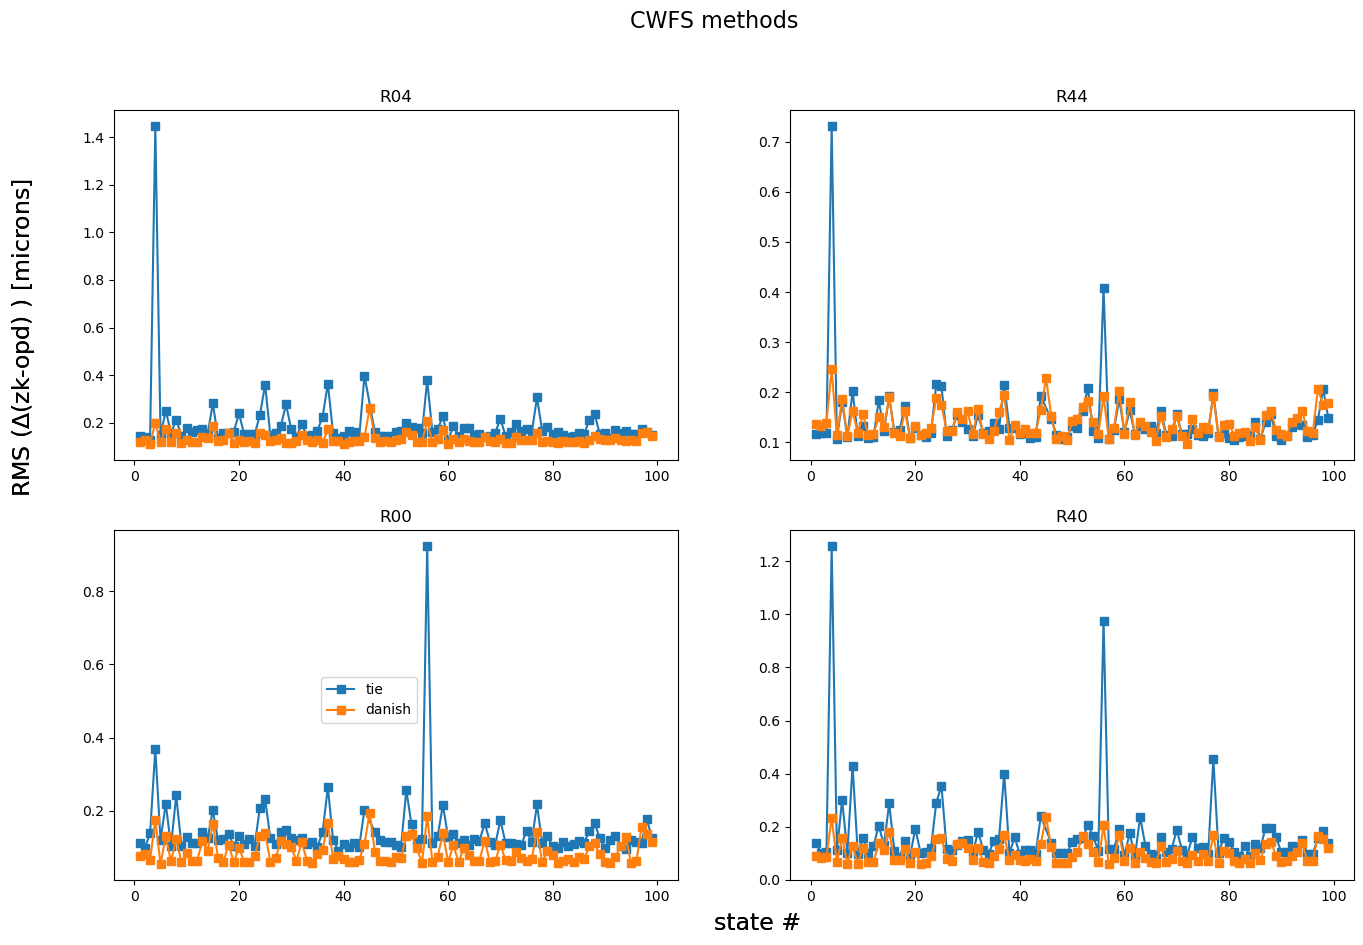

In [90]:
fig,axs = plt.subplots(2,2,figsize=(16,10))
ax = np.ravel(axs)


for method in rmss.keys():
    i=0
    for raft in rafts:
        mask = np.array(rmss[method][raft]) < 10
        states_select = np.array(list(pairing_results[method].keys()))[mask]
        rmss_select = np.array(rmss[method][raft])[mask]
        ax[i].plot(states_select, rmss_select, marker='s', label=f'{method}')
        ax[i].set_title(raft)
        i+=1
    
    fig.text(0.5,0.06,'state #', fontsize=17)
    fig.text(0.06,0.5,r'RMS ($\Delta$(zk-opd) ) [microns] ', rotation=90, fontsize=17)
fig.suptitle('CWFS methods', fontsize=16)
ax[2].legend(bbox_to_anchor=[0.55,.6])

Focus on the errant state:

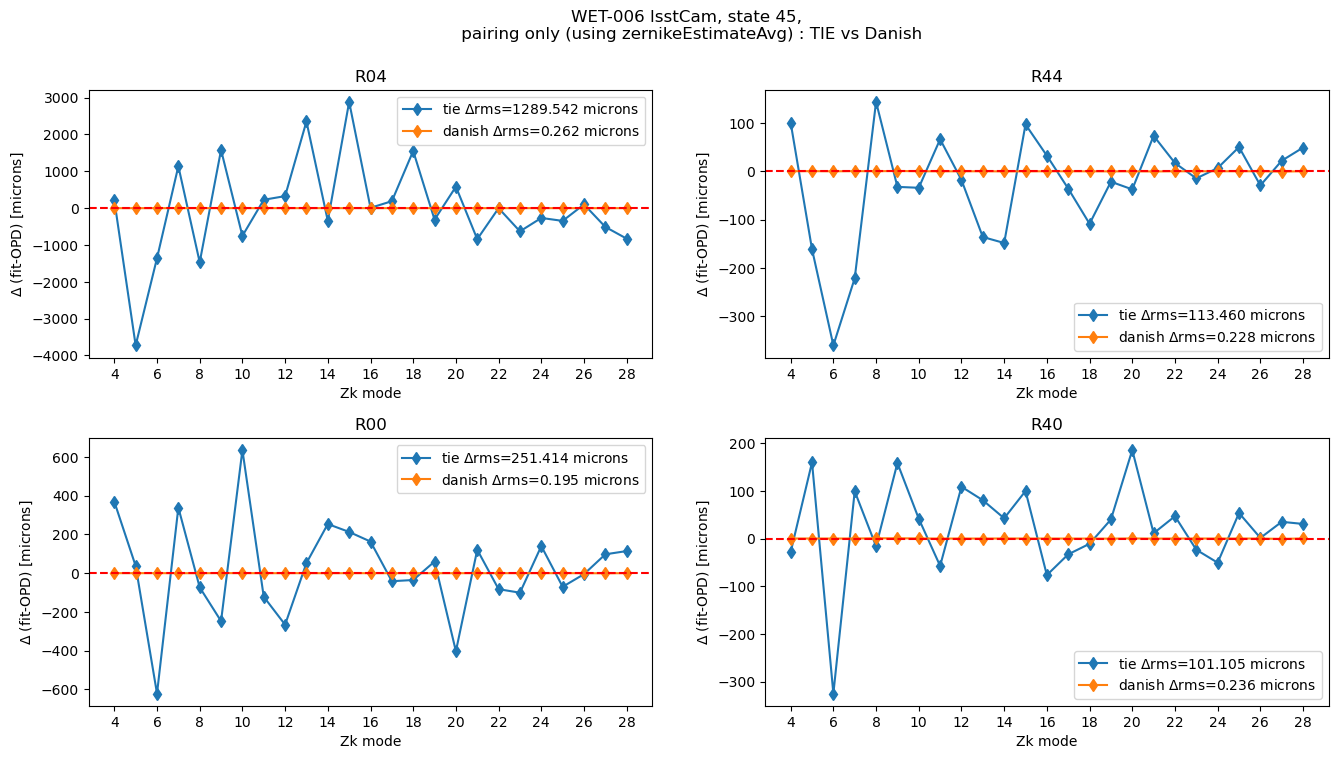

In [75]:
plot_lsstcam_fit_vs_opd(45, opd_raft_to_id, all_opd, pairing_results)

We see that while Danish has a result close to OPD, TIE is definitely suffering from a bad fit.   Show the stamps used:

In [77]:
dataRefs = registry.queryDatasets('donutStampsExtra', collections=[ 'WET-001_lsstCam_direct_TIE1'],
     where=f"instrument='LSSTCam' and detector.purpose='WAVEFRONT' and visit.seq_num = 2045").expanded()
refs = list(dataRefs)

In [78]:
refs

[DatasetRef(DatasetType('donutStampsExtra', {band, instrument, day_obs, detector, physical_filter, visit}, StampsBase), {instrument: 'LSSTCam', detector: 191, visit: 5024072302045, band: 'r', day_obs: 20240723, physical_filter: 'r_57'}, run='WET-001_lsstCam_direct_stamps/20241010T051647Z', id=c32a149d-48ce-4618-a6f0-4dd8c8afcae1),
 DatasetRef(DatasetType('donutStampsExtra', {band, instrument, day_obs, detector, physical_filter, visit}, StampsBase), {instrument: 'LSSTCam', detector: 195, visit: 5024072302045, band: 'r', day_obs: 20240723, physical_filter: 'r_57'}, run='WET-001_lsstCam_direct_stamps/20241010T051647Z', id=841ed23f-1c6e-4b43-9ea5-42be18190952),
 DatasetRef(DatasetType('donutStampsExtra', {band, instrument, day_obs, detector, physical_filter, visit}, StampsBase), {instrument: 'LSSTCam', detector: 199, visit: 5024072302045, band: 'r', day_obs: 20240723, physical_filter: 'r_57'}, run='WET-001_lsstCam_direct_stamps/20241010T051647Z', id=ea8fda84-e974-436d-a392-7412d342295e),
 

In [87]:
zkRaw = butler.get('zernikeEstimateRaw', dataId= refs[0].dataId, collections=['WET-001_lsstCam_direct_TIE1'])
zkRaw1 = butler.get('zernikeEstimateRaw', dataId= refs[0].dataId, collections=['WET-001_lsstCam_direct_Danish1'])


So these are gigantic values (in microns) ! Show the postISRCCD

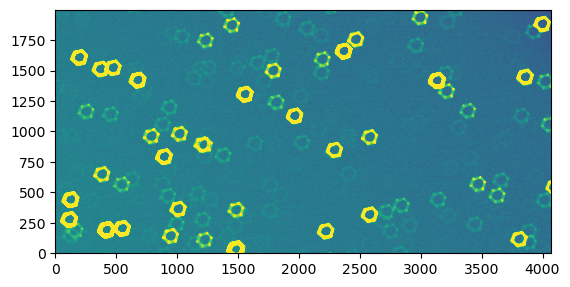

In [80]:
dataId = {'instrument':refs[0].dataId.instrument.name,
'detector':refs[0].dataId.detector.id,
'exposure':refs[0].dataId.visit.id,
'day_obs':refs[0].dataId.day_obs.id
         }
exposure = butler.get('postISRCCD', dataId = dataId, collections=['WET-001_lsstCam_ISR'])

zscale = ZScaleInterval()
d = exposure.image.array
vmin,vmax = zscale.get_limits(d)
plt.imshow(d, vmin=vmin,vmax=vmax, origin='lower')

Show OPD and Zernike fits for that exposure:

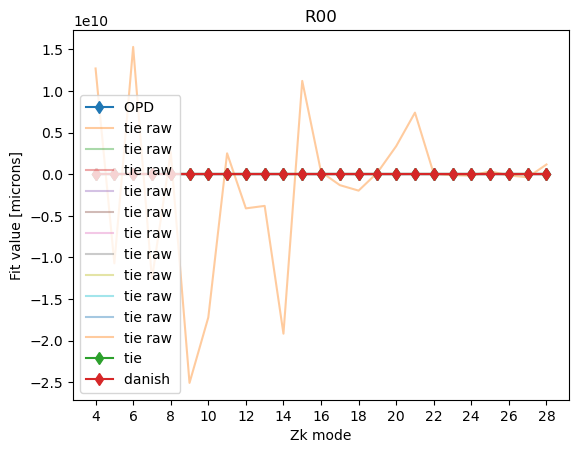

In [88]:
raft = refs[0].dataId.detector.raft
state = 45 
fig,ax = plt.subplots()

ax.set_title(raft )
opdId = opd_raft_to_id[raft] 
opd_zk = 0.001*np.array(all_opd[state][opdId][3:29])

ax.plot(np.arange(4,29), opd_zk, marker='d', label=f'OPD ')

# plot raw TIE
for i in range(len(zkRaw)):
   ax.plot(np.arange(4,29),zkRaw[i], alpha=0.4, label=f'tie raw')
    
for method in pairing_results.keys():
    # plot pairing  raw zks for danish and tie
    zkAvg = pairing_results[method][state][raft]
    ax.plot(np.arange(4,29),zkAvg[0], marker='d', label=f'{method} ')


  
ax.set_ylabel(r'Fit value [microns]')
ax.set_xlabel('Zk mode')
ax.set_xticks(np.arange(4,29,step=2))
#ax.axhline(0,ls='--', c='red')
ax.legend()



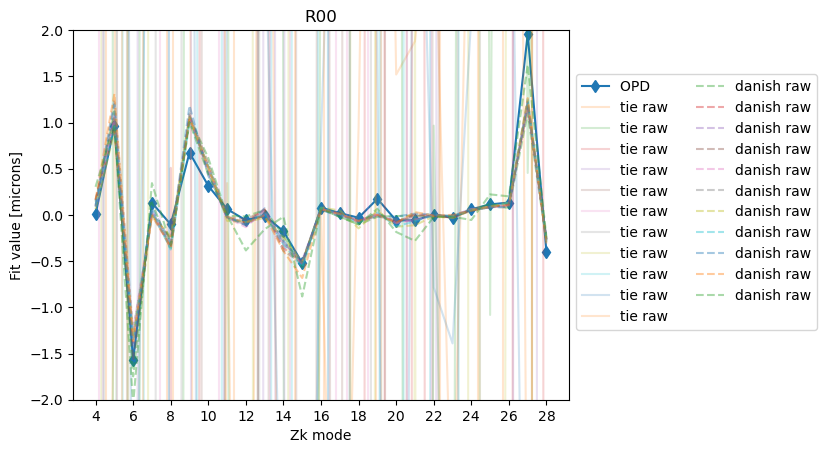

In [89]:
raft = refs[0].dataId.detector.raft
state = 45 
fig,ax = plt.subplots()

ax.set_title(raft )
opdId = opd_raft_to_id[raft] 
opd_zk = 0.001*np.array(all_opd[state][opdId][3:29])

ax.plot(np.arange(4,29), opd_zk, marker='d', label=f'OPD ')

# plot raw TIE
for i in range(len(zkRaw)):
   ax.plot(np.arange(4,29),zkRaw[i], alpha=0.2, label=f'tie raw')

# plot raw Danish 
for i in range(len(zkRaw1)):
   ax.plot(np.arange(4,29),zkRaw1[i], alpha=0.4,  ls='--',  label=f'danish raw')

ax.set_ylim(-2,2)
  
ax.set_ylabel(r'Fit value [microns]')
ax.set_xlabel('Zk mode')
ax.set_xticks(np.arange(4,29,step=2))
ax.legend(bbox_to_anchor=[1.0,0.9], ncols=2)



So for TIE all donut estimates  for that state are exceptionally bad. 

Marginalize across all detectors:

In [229]:
mean_per_state = {}
for method in rmss.keys():
    all_raft_data = []
    for raft in rafts:
        all_raft_data.append( rmss[method][raft])
    mean_per_state[method] = np.mean(all_raft_data,axis=0)

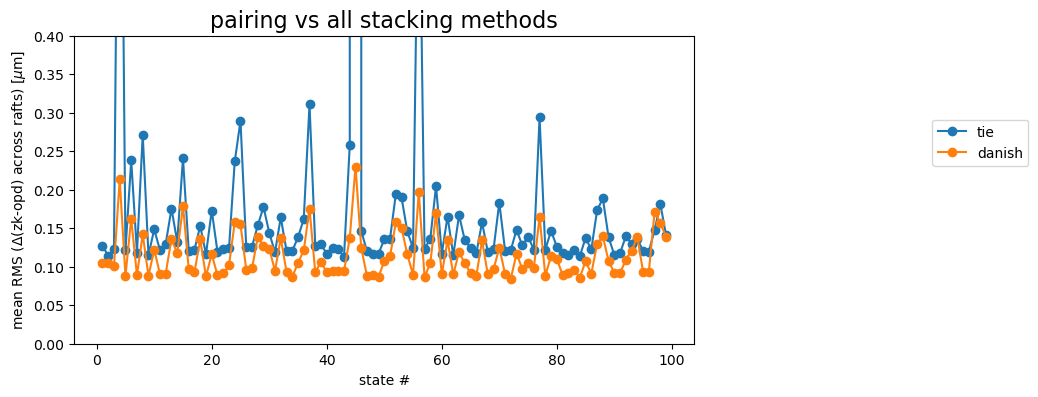

In [236]:


fig,ax = plt.subplots(1,1,figsize=(8,4))
j=0
cmap = cmaps['tab10']
for method in mean_per_state.keys():
    
    ax.plot(np.arange(1,100), mean_per_state[method], marker='o', label=f'{method}',
           c=cmap(j))
    j+=1
ax.set_ylim(0,0.4)
ax.set_xlabel('state #')
ax.set_ylabel(r'mean RMS ($\Delta$(zk-opd) across rafts) '+r'[$\mu$m]',)
ax.set_title('pairing vs all stacking methods', fontsize=16)
ax.legend(bbox_to_anchor=[1.55,0.75])

This shows that for majority of simulated states, Danish performs better than TIE. Given that, it should be the default method we use.